# Validation

- Start date: 1/3/25.
- End date: 14 days after that.
- LoS calculated in hours between the time of admission and discharge time.
- Theatre data merged with apc data


In [26]:
import pandas as pd
import sqlalchemy as sa
import numpy as np
import seaborn as sns
sns.set_theme(context='notebook', style='whitegrid')

import itertools

from matplotlib import pyplot as plt

from surgical_sim import Patient

sim_day_1 = pd.to_datetime("01/03/25", dayfirst=True)

In [27]:
engine = sa.create_engine(open("SQL_queries/engine.txt", 'r').read())

In [28]:
with engine.connect() as conn:
    theatre_df = pd.read_sql(open("SQL_queries\Theatre draft 2.1_cs_edit.sql").read(), con=conn.connection)

C:\Users\christopher.sampson\AppData\Local\Temp\ipykernel_11456\176183766.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  theatre_df = pd.read_sql(open("SQL_queries\Theatre draft 2.1_cs_edit.sql").read(), con=conn.connection)


In [29]:
theatre_df["SchDur"] = pd.to_numeric(theatre_df["SchDur"])

In [30]:
theatre_df["em_el_dc"].value_counts()

em_el_dc
EMERG    79
DCASE    38
ELECT    37
Name: count, dtype: int64

In [31]:
theatre_df = theatre_df[["SchOperatingRoom", "SchSurgeryDate", "SchSurgeryDateTime", "SchDur", "LoS", "em_el_dc", "ReferralDate"]]

theatre_df.isna().sum()

SchOperatingRoom       0
SchSurgeryDate         0
SchSurgeryDateTime     0
SchDur                 0
LoS                   15
em_el_dc               2
ReferralDate          33
dtype: int64

In [32]:
theatre_df["LoS"] = theatre_df["LoS"].fillna(theatre_df["LoS"].max())
theatre_df["ReferralDate"] = theatre_df["ReferralDate"].fillna(theatre_df["SchSurgeryDate"])

In [33]:
with engine.connect() as conn:
    occupancy_df = pd.read_sql(open("SQL_queries\\tno_inpatient_occupancy.sql").read(), con=conn.connection)

C:\Users\christopher.sampson\AppData\Local\Temp\ipykernel_11456\2138600331.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  occupancy_df = pd.read_sql(open("SQL_queries\\tno_inpatient_occupancy.sql").read(), con=conn.connection)


In [34]:
occupancy_df["sim_time"] = (occupancy_df['dst'] - sim_day_1) / pd.Timedelta(hours=1)

## Setting up the schedule

In [35]:
def create_schedule(theatre_df):
    hours_remaining = 0
    schedule = []
    counter = itertools.count()
    em_el_dc_mapping = {"DCASE":"Daycase", "EMERG":"Emergency", "ELECT":"Elective", None:"Emergency"}

    for schdateroom, schdf in theatre_df.groupby(["SchOperatingRoom", "SchSurgeryDate"]):

        sorted_df = schdf.sort_values(by=["SchSurgeryDateTime"])

        hour = int(round((sorted_df["SchSurgeryDateTime"].iloc[0] - sim_day_1) / pd.Timedelta(hours=1)))
        hours_total = (sorted_df["SchSurgeryDateTime"].iloc[-1] + pd.Timedelta(minutes=sorted_df["SchDur"].iloc[-1]) - sorted_df["SchSurgeryDateTime"].iloc[0]) / pd.Timedelta(hours=1)
        patients = []

        patient_type = em_el_dc_mapping[schdf["em_el_dc"].mode()[0]]


        for _, row in sorted_df.iterrows():
            arrival_time = (row.ReferralDate - sim_day_1) / pd.Timedelta(hours=1)
            

            patients.append(Patient(id=f"{em_el_dc_mapping[row.em_el_dc]}{next(counter)}", arrival_time=arrival_time, surgery_duration=row.SchDur / 60, recovery_time=row.LoS))

        schedule.append([hour, patient_type, hours_total, hours_remaining, patients])


    schedule = pd.DataFrame(schedule, columns = ["hour", "patient_type", "hours_total", "hours_remaining", "patients"]).sort_values(by="hour")
    schedule = schedule[schedule["hour"] <= 14*24]

    unprocessed_schedule = {
        hour: [{r[0]:r[1]} for r in data[["patient_type", "hours_total"]].values]
        for hour, data in schedule.groupby("hour")
    }
    
    return schedule, unprocessed_schedule

### Plotting

In [74]:
def plot_graph(metrics, occupancy_df=occupancy_df):
    metrics["bed_event"].sort(key=lambda e: (e[0], e[1]))

    bed_events = np.array(metrics["bed_event"])
    beds = bed_events[:, 1].cumsum()
    df_beds = pd.DataFrame(np.hstack([bed_events, beds.reshape((-1, 1))]), columns=["Simulation time", "Change", "Occupied beds"]).drop_duplicates(subset="Simulation time", keep='last')


    metrics["surgical_event"].sort(key=lambda e: (e[0], e[1]))

    surgical_event = np.array(metrics["surgical_event"])
    surgeries = surgical_event[:, 1].cumsum()
    df_surgery = pd.DataFrame(np.hstack([surgical_event, surgeries.reshape((-1, 1))]), columns=["Simulation time", "Change", "Occupied theatres"]).drop_duplicates(subset="Simulation time", keep='last')

    metrics["cc_bed_event"].sort(key=lambda e: (e[0], e[1]))

    cc_bed_events = np.array(metrics["cc_bed_event"])
    cc_beds = cc_bed_events[:, 1].cumsum()
    df_cc_beds = pd.DataFrame(np.hstack([cc_bed_events, cc_beds.reshape((-1, 1))]), columns=["Simulation time", "Change", "Occupied CC beds"]).drop_duplicates(subset="Simulation time", keep='last')


    fig, ax = plt.subplots(3,1, sharex=True)
    fig.set_figheight(8)
    fig.set_figwidth(10)

    sns.lineplot(df_beds, x="Simulation time", y="Occupied beds", drawstyle='steps-post', label="Predicted occupancy", ax=ax[0])
    sns.lineplot(occupancy_df, x="sim_time", y="occupancy", drawstyle='steps-post', label="Actual occupancy", ax=ax[0])
    ax[0].set_xlabel("Simulation Time")
    ax[0].set_ylabel("Occupied Beds")

    sns.lineplot(df_surgery, x="Simulation time", y="Occupied theatres", drawstyle='steps-post', label="occupied theatres", ax=ax[1])
    ax[1].set_xlabel("Simulation Time")
    ax[1].set_ylabel("Occupied Theatres")

    sns.lineplot(df_cc_beds, x="Simulation time", y="Occupied CC beds", drawstyle='steps-post', label="occupied CC beds", ax=ax[2])
    ax[0].set_xlabel("Simulation Time")
    ax[0].set_ylabel("Occupied Beds")


def plot_wait_times(experiment, theatre_df, prefix="val"):
    patient_df = pd.DataFrame([(patient.id, patient.surgical_time, patient.arrival_time) for patient in experiment.patients], columns=["id", "surgery_time", "arrival_time"])

    for patient_type in ["Emergency", "Elective", "Daycase"]:
        patient_type_df = patient_df.loc[patient_df.id.str.contains(patient_type), ["surgery_time", "arrival_time"]]

        _, ax = plt.subplots(2,1, sharex=True, sharey=True)

        bins_conversion = {"Emergency": range(0, 10), "Daycase": range(0, 1400, 140), "Elective":20}
        bins = bins_conversion[patient_type]
        sns.histplot((patient_type_df["surgery_time"] - patient_type_df["arrival_time"])/24, bins=bins, label="Predicted", ax=ax[0])
        ax[0].set_title(patient_type)

        conversion = {"Emergency":"EMERG", "Elective":"ELECT","Daycase":"DCASE"}
        mask = (theatre_df["em_el_dc"] == conversion[patient_type]) & (theatre_df["SchSurgeryDate"] < '15/3/2025')
        sns.histplot((theatre_df.loc[mask, "SchSurgeryDate"] - theatre_df.loc[mask, "ReferralDate"]) / pd.Timedelta(days=1), ax=ax[1], bins=bins, label="Actual")

        ax[0].legend()
        ax[1].legend()
        plt.xlabel("Days waiting")
        plt.savefig(f"images/{prefix}_{patient_type}_wait_times.png", dpi=600)
        plt.show()



## Test Scenario 1: No initial occupancy

In [91]:
from collections import defaultdict
import simpy
from surgical_sim import setup_logger, daily_planning, scheduler, Experiment, Schedule

NUM_BEDS = 100
NUM_CC_BEDS = 16

s = Schedule([])

schedule, unprocessed_schedule = create_schedule(theatre_df)
schedule = schedule.reset_index(drop=True)

s.processed_schedule = schedule
s._Schedule__schedule = unprocessed_schedule

experiment = Experiment(max_emergency_wait=480)
experiment.patients = [*itertools.chain.from_iterable(s.processed_schedule["patients"].values.tolist())]

metrics = defaultdict(lambda : [])
env = simpy.Environment()
logger = setup_logger(env)

beds = simpy.Resource(env, capacity=NUM_BEDS)
cc_beds = simpy.Resource(env, capacity=NUM_CC_BEDS)

env.process(daily_planning(env, beds, s, experiment))
env.process(scheduler(env, beds, cc_beds, experiment, s, metrics))

env.run(until=14*24)


INFO - 0.00 - New day!!!
INFO - 0.00 - 0 beds used, []
INFO - 0.00 - 0 patients are breaching! []
INFO - 9.00 - Sending Emergency: [Patient(id='Emergency108', arrival_time=0.0, surgical_time=None, discharge_time=None, surgery_duration=2.0, recovery_time=795.0, cancellations=[]), Patient(id='Emergency109', arrival_time=0.0, surgical_time=None, discharge_time=None, surgery_duration=1.0, recovery_time=795.0, cancellations=[]), Patient(id='Emergency110', arrival_time=0.0, surgical_time=None, discharge_time=None, surgery_duration=1.0, recovery_time=795.0, cancellations=[]), Patient(id='Emergency111', arrival_time=0.0, surgical_time=None, discharge_time=None, surgery_duration=1.5, recovery_time=795.0, cancellations=[])] to surgery.
INFO - 9.00 - Sending Elective: [Patient(id='Elective46', arrival_time=0.0, surgical_time=None, discharge_time=None, surgery_duration=4.0, recovery_time=795.0, cancellations=[])] to surgery.
INFO - 9.00 - Requesting cc bed for patient Patient(id='Emergency108', ar

### Analysis

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

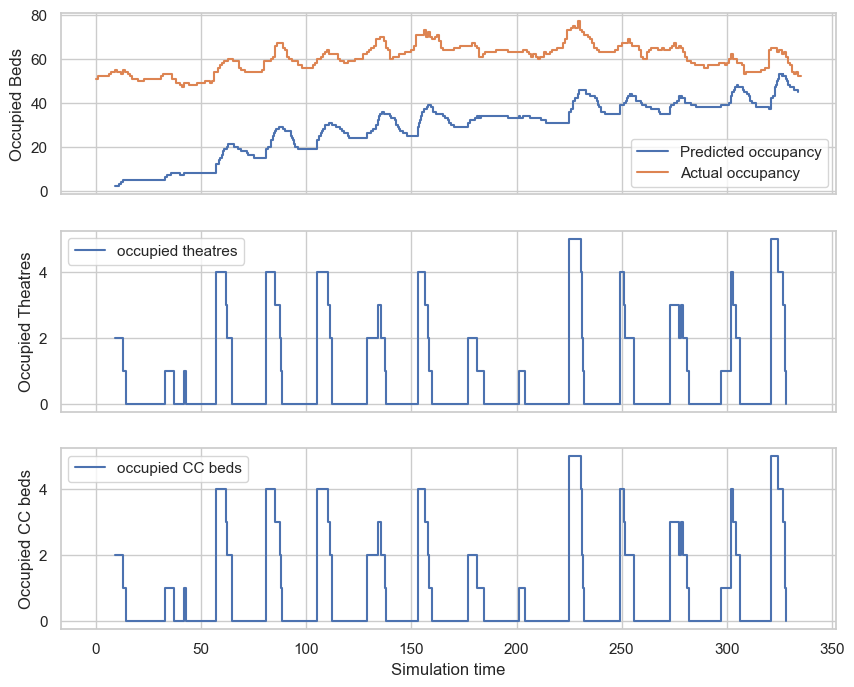

In [38]:
plot_graph(metrics)

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

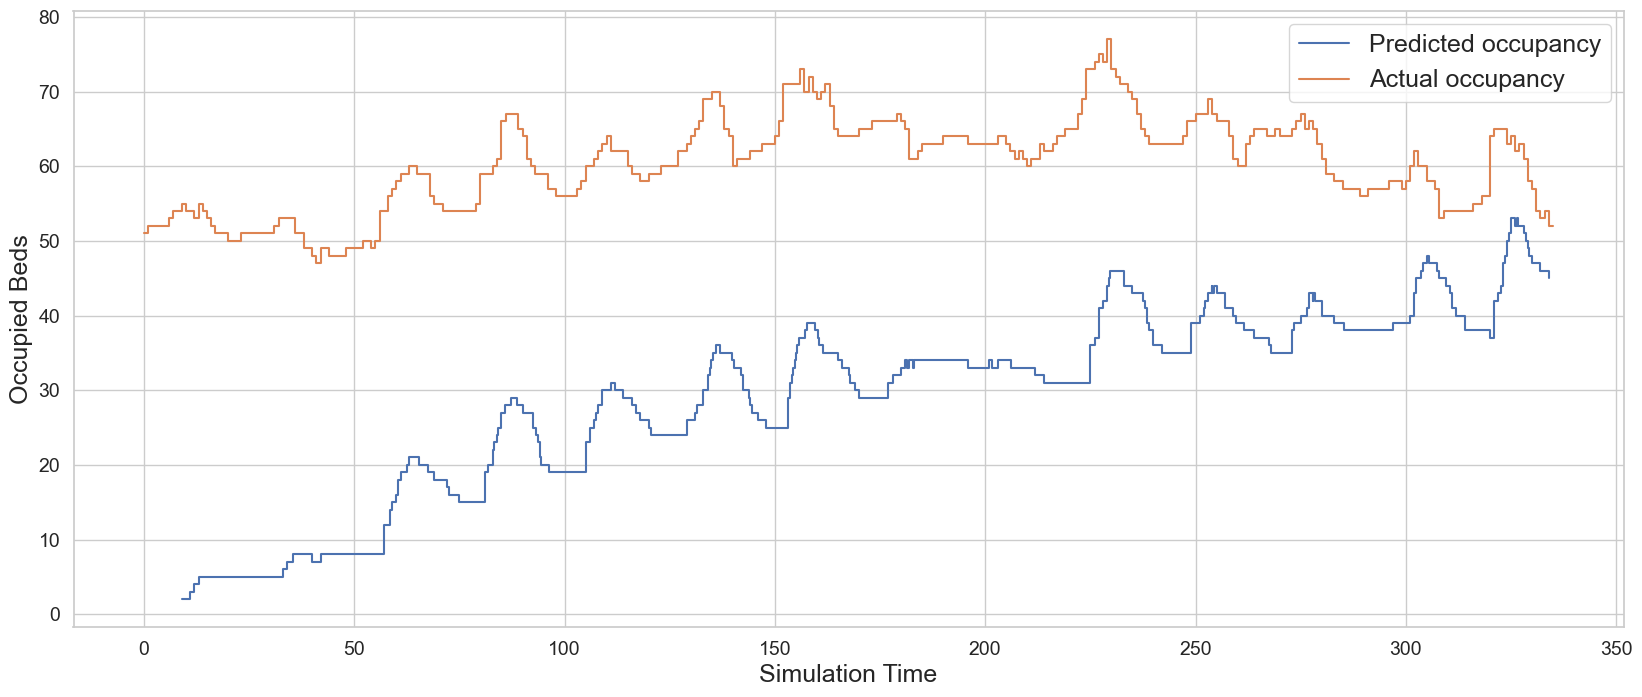

In [92]:
metrics["bed_event"].sort(key=lambda e: (e[0], e[1]))

bed_events = np.array(metrics["bed_event"])
beds = bed_events[:, 1].cumsum()
df_beds = pd.DataFrame(np.hstack([bed_events, beds.reshape((-1, 1))]), columns=["Simulation time", "Change", "Occupied beds"]).drop_duplicates(subset="Simulation time", keep='last')


fig = plt.figure(figsize=(20,8))

ax = sns.lineplot(df_beds, x="Simulation time", y="Occupied beds", drawstyle='steps-post', label="Predicted occupancy")
sns.lineplot(occupancy_df, x="sim_time", y="occupancy", drawstyle='steps-post', label="Actual occupancy", ax=ax)
plt.legend(fontsize=18)
ax.set_xlabel("Simulation Time", )
ax.set_ylabel("Occupied Beds")

ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

plt.savefig("images/val1_no_init_occ.png", dpi=600)

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


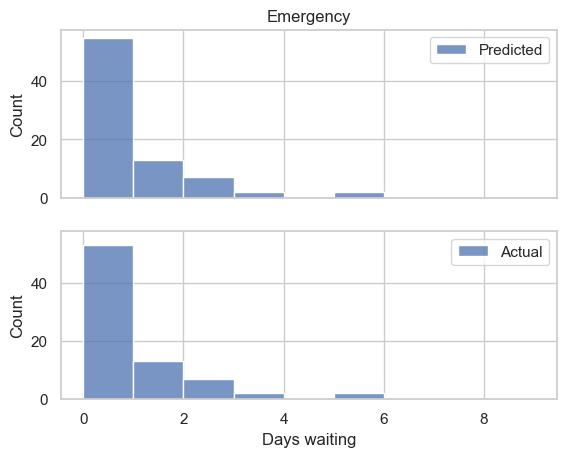

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


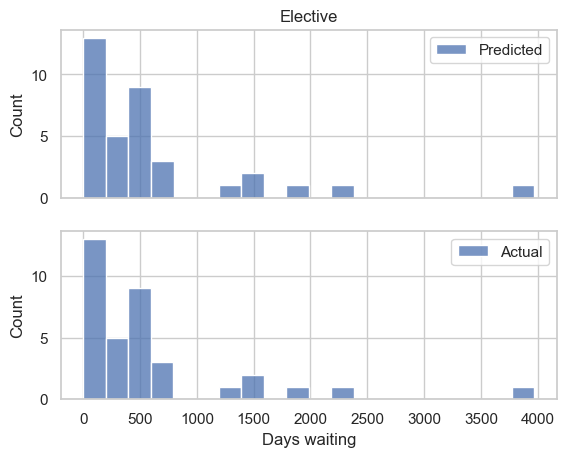

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


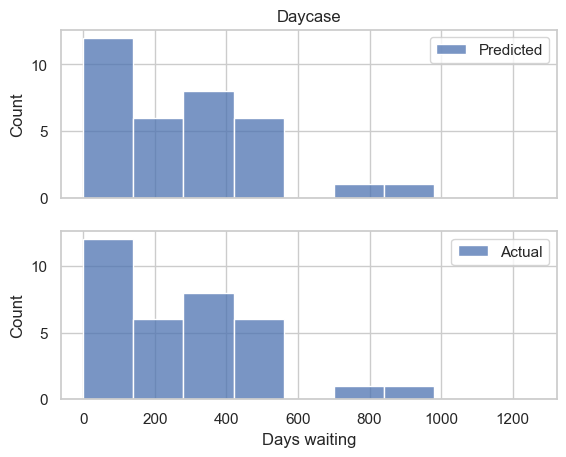

In [75]:
plot_wait_times(experiment, theatre_df, "val1")

## Test Scenario 2: Initial occupancy

In [76]:
with engine.connect() as conn:
    init_occupancy_df = pd.read_sql(open("SQL_queries\\tno_inpatient_initial_occupancy.sql").read(), con=conn.connection)

C:\Users\christopher.sampson\AppData\Local\Temp\ipykernel_11456\1782173618.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  init_occupancy_df = pd.read_sql(open("SQL_queries\\tno_inpatient_initial_occupancy.sql").read(), con=conn.connection)


In [77]:
init_occupancy_df.isna().sum() # current inpatients

em_el_dc         0
Remaining_los    1
dtype: int64

In [78]:
init_occupancy_df = init_occupancy_df.fillna(init_occupancy_df.max()) # Gaps are current inpatients

In [93]:
def bed_preload(env, beds, remaining_los, metrics):
    with beds.request() as bed_req:
        yield bed_req
        metrics["bed_event"].append((env.now, 1))
        yield env.timeout(remaining_los)
        metrics["bed_event"].append((env.now, -1))

def initialise_ward(env, beds, init_occupancy_df, metrics):
    for remaining_los in init_occupancy_df["Remaining_los"].values:
        env.process(bed_preload(env, beds, remaining_los, metrics))

In [100]:
NUM_BEDS = 100
NUM_CC_BEDS = 16

s = Schedule([])

schedule, unprocessed_schedule = create_schedule(theatre_df)
schedule = schedule.reset_index(drop=True)

s.processed_schedule = schedule
s._Schedule__schedule = unprocessed_schedule

experiment = Experiment(max_emergency_wait=480)
experiment.patients = [*itertools.chain.from_iterable(s.processed_schedule["patients"].values.tolist())]

metrics = defaultdict(lambda : [])
env = simpy.Environment()
logger = setup_logger(env)

beds = simpy.Resource(env, capacity=NUM_BEDS)
cc_beds = simpy.Resource(env, capacity=NUM_CC_BEDS)

initialise_ward(env, beds, init_occupancy_df, metrics)

env.process(daily_planning(env, beds, s, experiment))
env.process(scheduler(env, beds, cc_beds, experiment, s, metrics))

env.run(until=14*24)


INFO - 0.00 - New day!!!
INFO - 0.00 - 51 beds used, [<Request() object at 0x134de231250>, <Request() object at 0x134dbcae810>, <Request() object at 0x134e0694090>, <Request() object at 0x134dfd12390>, <Request() object at 0x134e0bc4b10>, <Request() object at 0x134e0bc4bd0>, <Request() object at 0x134dd237310>, <Request() object at 0x134dd1d7cd0>, <Request() object at 0x134dfc7ecd0>, <Request() object at 0x134d8300dd0>, <Request() object at 0x134d8302150>, <Request() object at 0x134dd1be050>, <Request() object at 0x134de219a50>, <Request() object at 0x134dd1ef810>, <Request() object at 0x134dd1ec510>, <Request() object at 0x134dd1f9150>, <Request() object at 0x134db9490d0>, <Request() object at 0x134e0b97550>, <Request() object at 0x134e0b95d90>, <Request() object at 0x134dd27f4d0>, <Request() object at 0x134dd27e290>, <Request() object at 0x134dd27ff90>, <Request() object at 0x134dd27e210>, <Request() object at 0x134dd29dc10>, <Request() object at 0x134dd29e690>, <Request() object at 

### Analysis

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

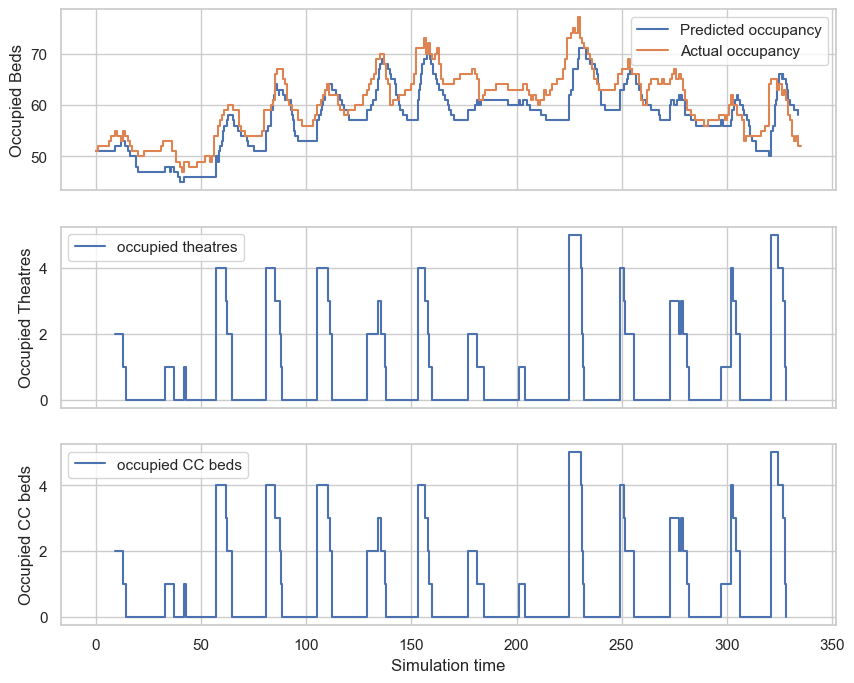

In [101]:
plot_graph(metrics)

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

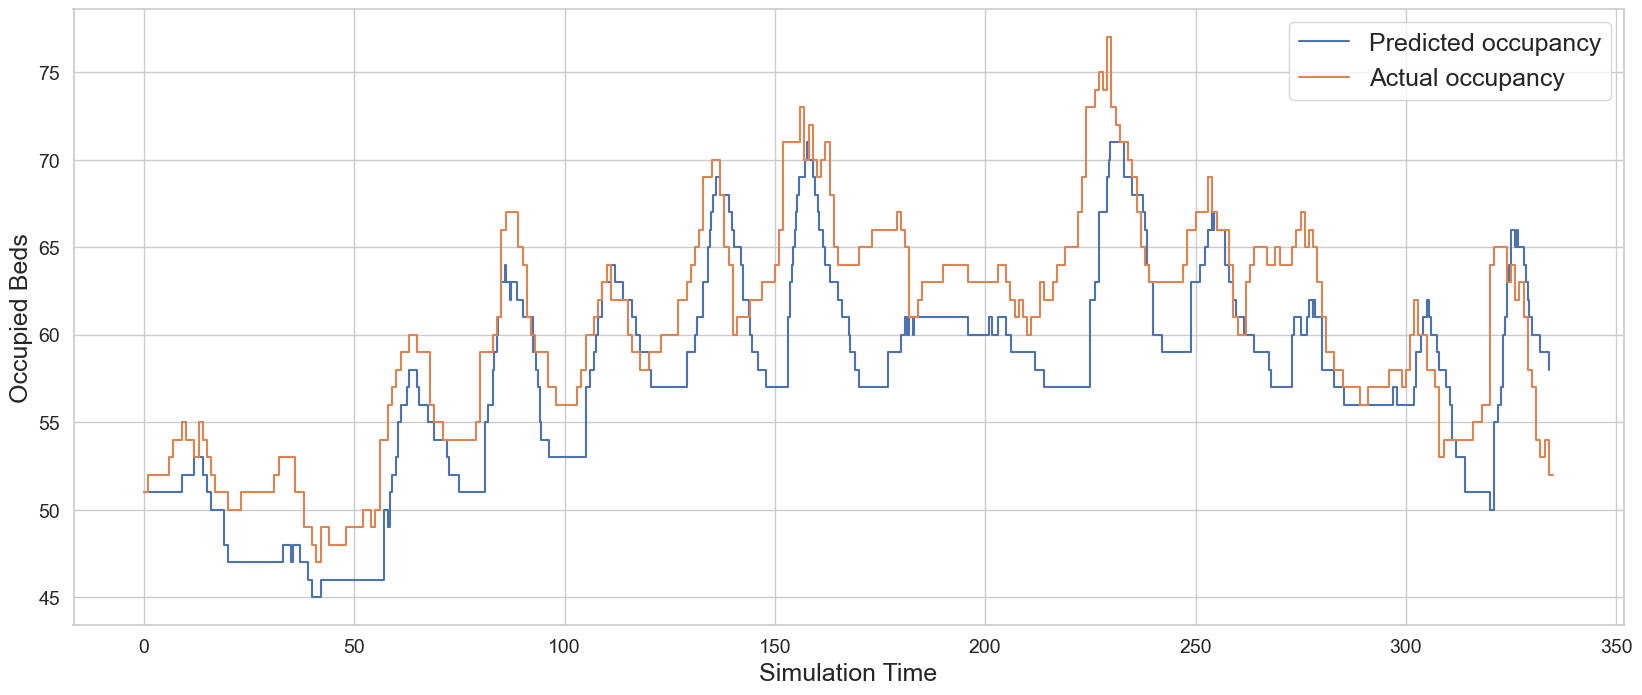

In [102]:
metrics["bed_event"].sort(key=lambda e: (e[0], e[1]))

bed_events = np.array(metrics["bed_event"])
beds = bed_events[:, 1].cumsum()
df_beds = pd.DataFrame(np.hstack([bed_events, beds.reshape((-1, 1))]), columns=["Simulation time", "Change", "Occupied beds"]).drop_duplicates(subset="Simulation time", keep='last')


fig = plt.figure(figsize=(20,8))

ax = sns.lineplot(df_beds, x="Simulation time", y="Occupied beds", drawstyle='steps-post', label="Predicted occupancy")
sns.lineplot(occupancy_df, x="sim_time", y="occupancy", drawstyle='steps-post', label="Actual occupancy", ax=ax)
plt.legend(fontsize=18)
ax.set_xlabel("Simulation Time", )
ax.set_ylabel("Occupied Beds")

ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

plt.savefig("images/val2_init_occ.png", dpi=600)

In [103]:
metrics["bed_event"].sort(key=lambda e: (e[0], e[1]))

bed_events = np.array(metrics["bed_event"])
beds = bed_events[:, 1].cumsum()
df_beds = pd.DataFrame(np.hstack([bed_events, beds.reshape((-1, 1))]), columns=["Simulation time", "Change", "Occupied beds"]).drop_duplicates(subset="Simulation time", keep='last')

predicted_occ_df = df_beds.set_index("Simulation time")

mae = (predicted_occ_df.reindex(range(0, 14*24)).ffill()["Occupied beds"] - occupancy_df.set_index('dst').resample('h').ffill().reset_index(drop=True)["occupancy"]).abs().mean()
print(f"MAE: {mae}")

MAE: 3.5029761904761907


c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


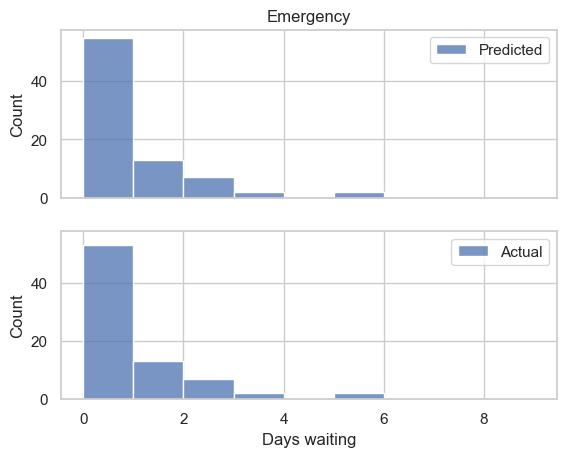

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


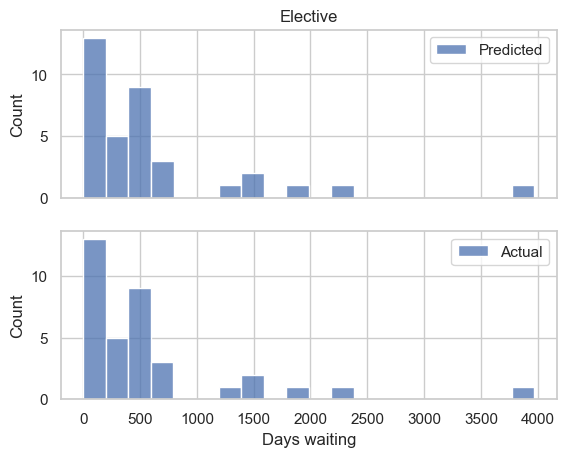

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


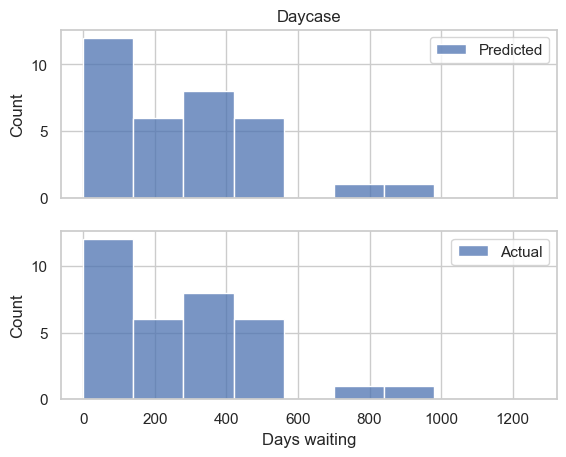

In [104]:
plot_wait_times(experiment, theatre_df, "val2")

## Scenario 3: Examining Occupancy

C:\Users\christopher.sampson\AppData\Local\Temp\ipykernel_11456\3600890249.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  occupancy_home_df = pd.read_sql(open("SQL_queries\\tno_inpatient_occupancy_source_home.sql").read(), con=conn.connection)
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py

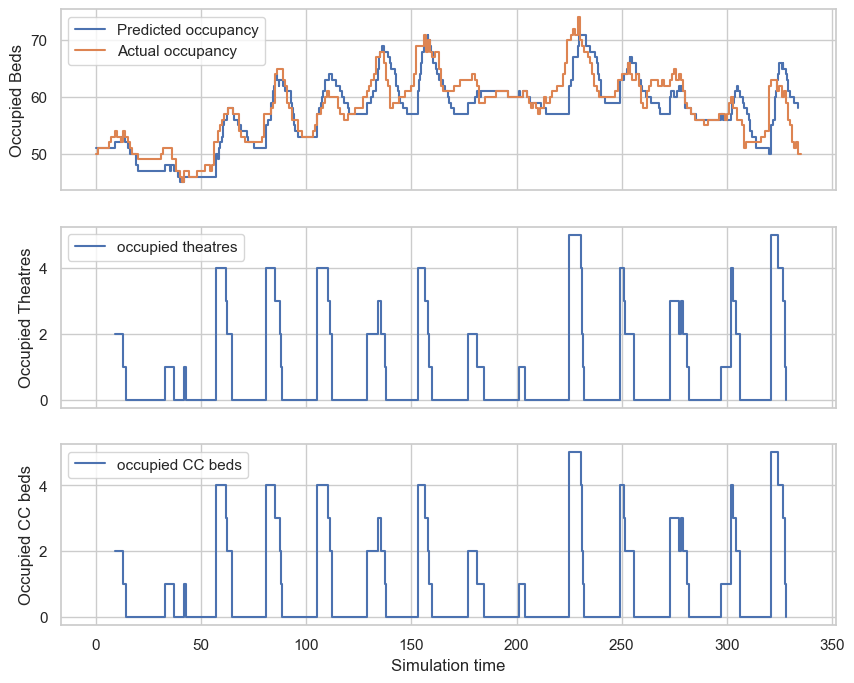

In [105]:
with engine.connect() as conn:
    occupancy_home_df = pd.read_sql(open("SQL_queries\\tno_inpatient_occupancy_source_home.sql").read(), con=conn.connection)

occupancy_home_df["sim_time"] = (occupancy_df['dst'] - sim_day_1) / pd.Timedelta(hours=1)

metrics["bed_event"].sort(key=lambda e: (e[0], e[1]))

bed_events = np.array(metrics["bed_event"])
beds = bed_events[:, 1].cumsum()
df_beds = pd.DataFrame(np.hstack([bed_events, beds.reshape((-1, 1))]), columns=["Simulation time", "Change", "Occupied beds"]).drop_duplicates(subset="Simulation time", keep='last')


plot_graph(metrics, occupancy_home_df)

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

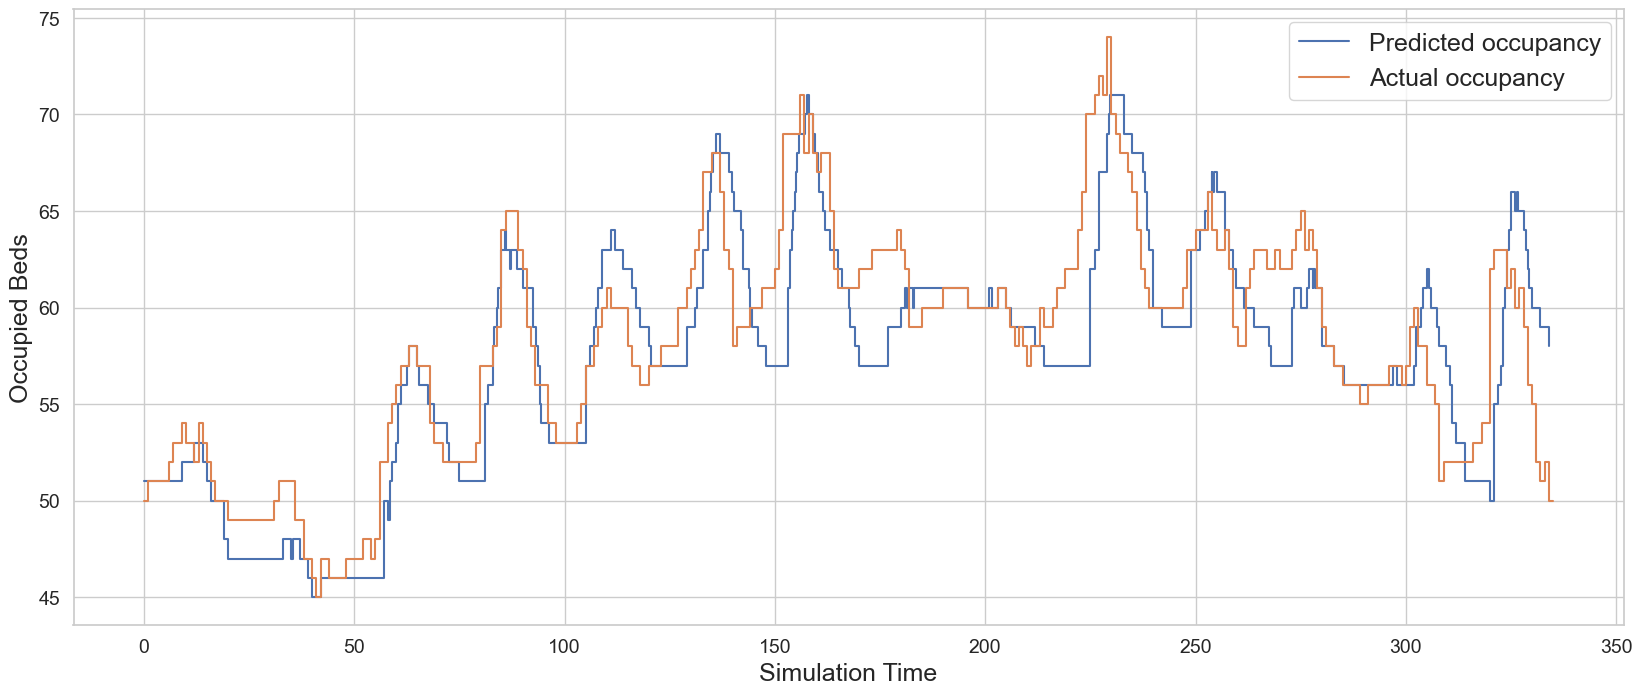

In [106]:
metrics["bed_event"].sort(key=lambda e: (e[0], e[1]))

bed_events = np.array(metrics["bed_event"])
beds = bed_events[:, 1].cumsum()
df_beds = pd.DataFrame(np.hstack([bed_events, beds.reshape((-1, 1))]), columns=["Simulation time", "Change", "Occupied beds"]).drop_duplicates(subset="Simulation time", keep='last')


fig = plt.figure(figsize=(20,8))

ax = sns.lineplot(df_beds, x="Simulation time", y="Occupied beds", drawstyle='steps-post', label="Predicted occupancy")
sns.lineplot(occupancy_home_df, x="sim_time", y="occupancy", drawstyle='steps-post', label="Actual occupancy", ax=ax)
plt.legend(fontsize=18)
ax.set_xlabel("Simulation Time", )
ax.set_ylabel("Occupied Beds")

ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

plt.savefig("images/val3_altered_occ.png", dpi=600)

In [107]:
mae = (predicted_occ_df.reindex(range(0, 14*24)).ffill()["Occupied beds"] - occupancy_home_df.set_index('dst').resample('h').ffill().reset_index(drop=True)["occupancy"]).abs().mean()
print(f"MAE: {mae}")

MAE: 2.619047619047619


## Scenario 4: Allowing scheduling algorithm

In [108]:
NUM_BEDS = 100
NUM_CC_BEDS = 16

s = Schedule([])

blank_schedule = schedule.copy()
blank_schedule["patients"] = [[] for _ in range(len(blank_schedule))]

s.processed_schedule = blank_schedule
s.processed_schedule["hours_remaining"] = s.processed_schedule["hours_total"]

schedule, unprocessed_schedule = create_schedule(theatre_df)
s._Schedule__schedule = unprocessed_schedule

experiment = Experiment(max_emergency_wait=480)
experiment.patients = [*itertools.chain.from_iterable(schedule["patients"].values.tolist())]

for patient in experiment.patients:
    if patient.arrival_time <0:
        s.schedule_patients([patient], patient.surgery_duration)

def patient_generator(env, schedule, experiment):
    while True:
        for patient in experiment.patients:
            if patient.arrival_time == env.now:
                logger.info(f"scheduling patient {patient} now")
                schedule.schedule_patients([patient], env.now)

        yield env.timeout(1)

metrics = defaultdict(lambda : [])
env = simpy.Environment()
logger = setup_logger(env)

beds = simpy.Resource(env, capacity=NUM_BEDS)
cc_beds = simpy.Resource(env, capacity=NUM_CC_BEDS)

initialise_ward(env, beds, init_occupancy_df, metrics)

env.process(patient_generator(env, s, experiment))
env.process(daily_planning(env, beds, s, experiment))
env.process(scheduler(env, beds, cc_beds, experiment, s, metrics))

env.run(until=14*24)


INFO - 336.00 - Scheduling Daycase16 for 57
INFO - 336.00 - Scheduling Elective17 for 9
INFO - 336.00 - Scheduling Elective18 for 57
INFO - 336.00 - Scheduling Elective19 for 57
INFO - 336.00 - Scheduling Daycase79 for 57
INFO - 336.00 - Scheduling Daycase80 for 57
INFO - 336.00 - Scheduling Elective47 for 57
INFO - 336.00 - Scheduling Daycase48 for 57
INFO - 336.00 - Scheduling Daycase0 for 57
INFO - 336.00 - Scheduling Daycase3 for 57
INFO - 336.00 - Scheduling Daycase4 for 57
INFO - 336.00 - Scheduling Daycase5 for 57
INFO - 336.00 - Scheduling Elective82 for 81
INFO - 336.00 - Scheduling Elective83 for 81
INFO - 336.00 - Scheduling Elective49 for 81
INFO - 336.00 - Scheduling Elective50 for 81
INFO - 336.00 - Scheduling Daycase51 for 81
INFO - 336.00 - Scheduling Elective52 for 105
INFO - 336.00 - Scheduling Elective85 for 81
INFO - 336.00 - Scheduling Elective20 for 105
INFO - 336.00 - Scheduling Daycase54 for 81
INFO - 336.00 - Scheduling Elective55 for 9
INFO - 336.00 - Scheduli

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

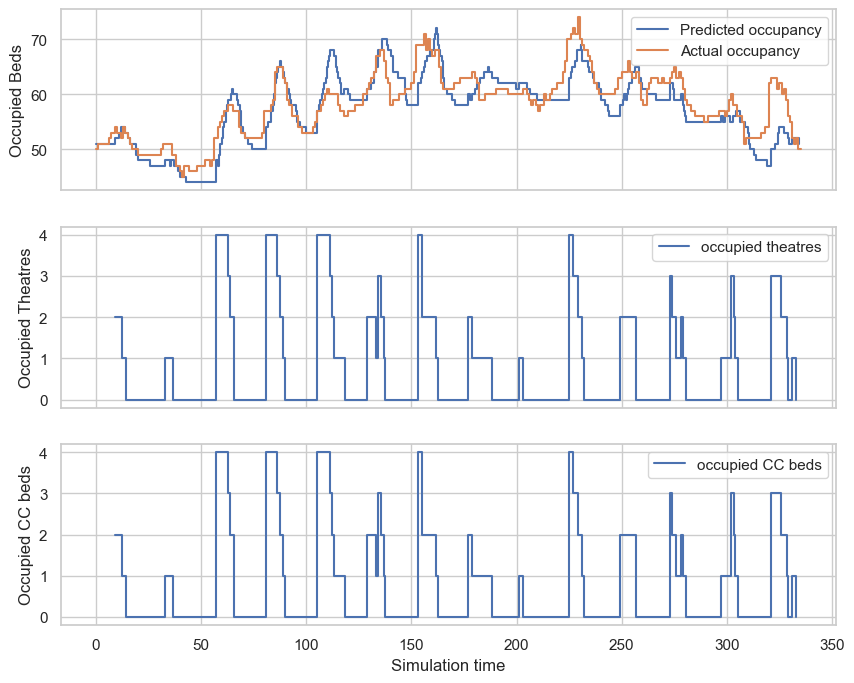

In [109]:
plot_graph(metrics, occupancy_home_df)

In [110]:
metrics["bed_event"].sort(key=lambda e: (e[0], e[1]))

bed_events = np.array(metrics["bed_event"])
beds = bed_events[:, 1].cumsum()
df_beds = pd.DataFrame(np.hstack([bed_events, beds.reshape((-1, 1))]), columns=["Simulation time", "Change", "Occupied beds"]).drop_duplicates(subset="Simulation time", keep='last')

predicted_occ_df = df_beds.set_index("Simulation time")

mae = (predicted_occ_df.reindex(range(0, 14*24)).ffill()["Occupied beds"] - occupancy_home_df.set_index('dst').resample('h').ffill().reset_index(drop=True)["occupancy"]).abs().mean()
print(f"MAE: {mae}")

MAE: 2.6101190476190474


c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

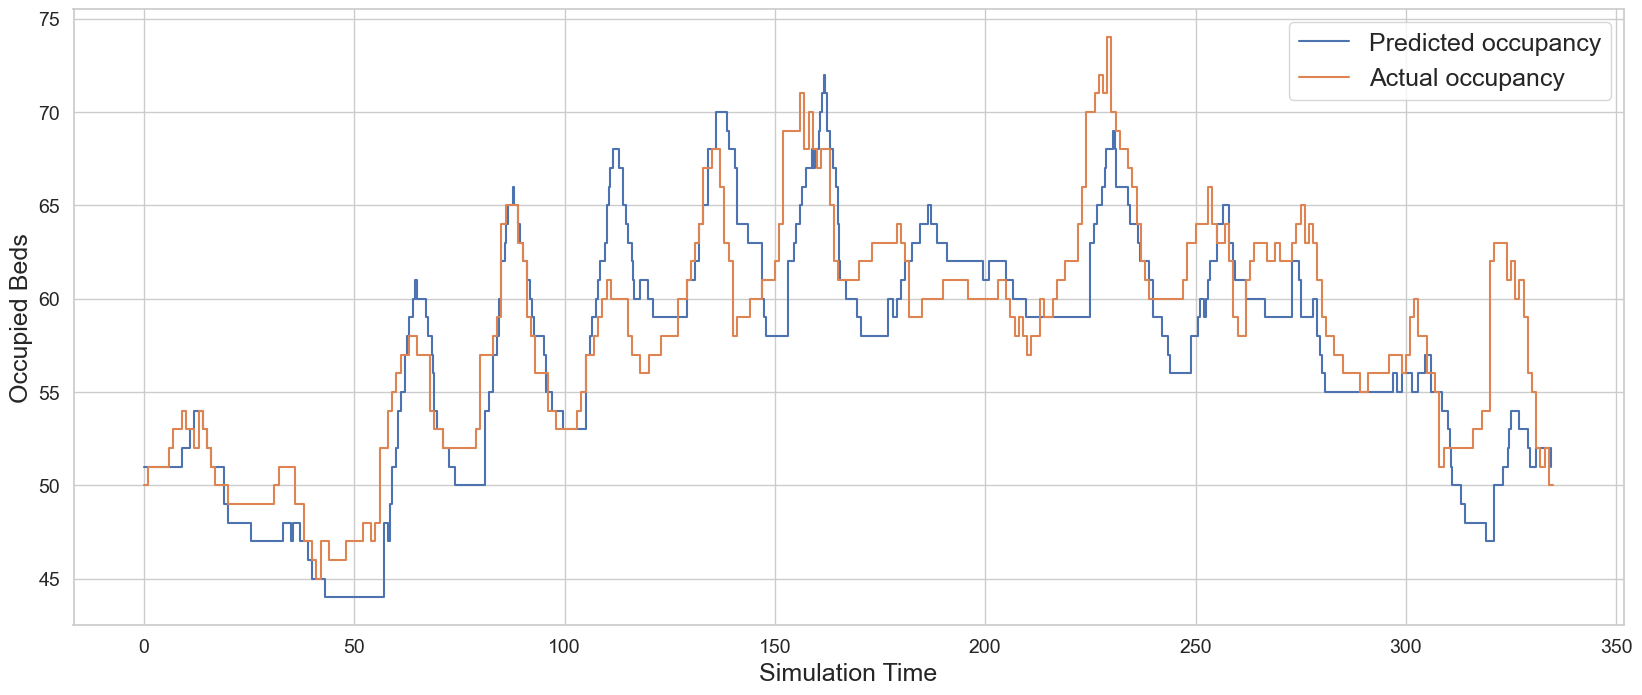

In [111]:
metrics["bed_event"].sort(key=lambda e: (e[0], e[1]))

bed_events = np.array(metrics["bed_event"])
beds = bed_events[:, 1].cumsum()
df_beds = pd.DataFrame(np.hstack([bed_events, beds.reshape((-1, 1))]), columns=["Simulation time", "Change", "Occupied beds"]).drop_duplicates(subset="Simulation time", keep='last')


fig = plt.figure(figsize=(20,8))

ax = sns.lineplot(df_beds, x="Simulation time", y="Occupied beds", drawstyle='steps-post', label="Predicted occupancy")
sns.lineplot(occupancy_home_df, x="sim_time", y="occupancy", drawstyle='steps-post', label="Actual occupancy", ax=ax)
plt.legend(fontsize=18)
ax.set_xlabel("Simulation Time", )
ax.set_ylabel("Occupied Beds")

ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

plt.savefig("images/val4_scheduling.png", dpi=600)

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


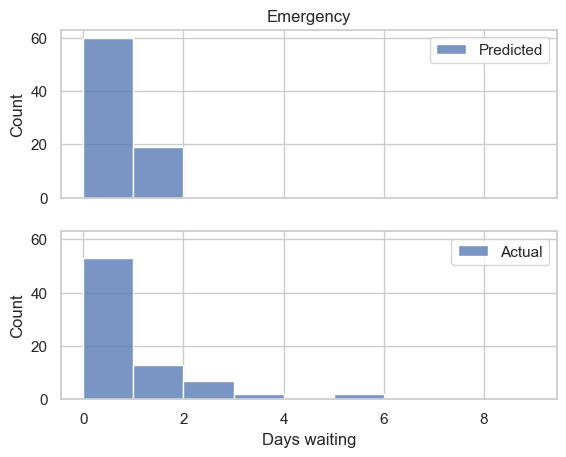

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


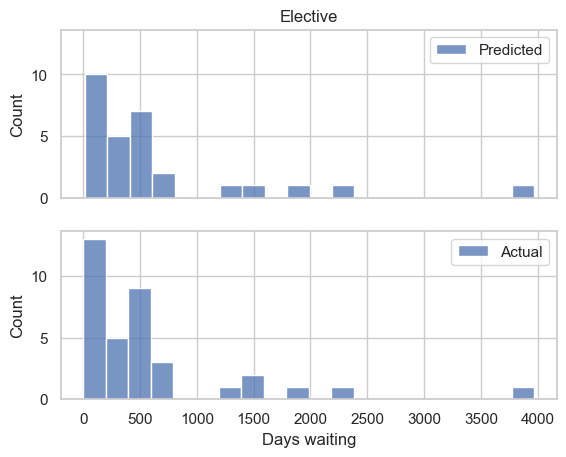

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


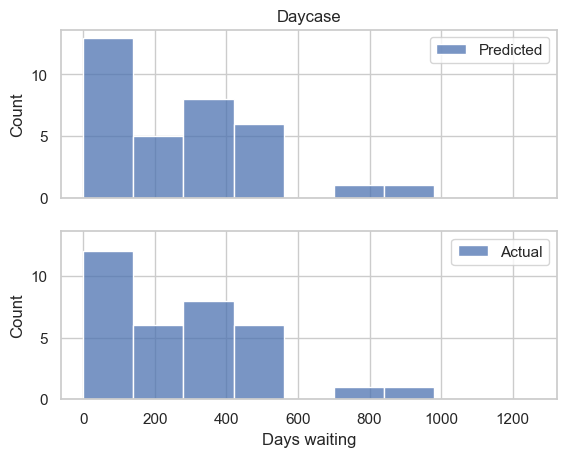

In [112]:
plot_wait_times(experiment, theatre_df, "val4")
# Emergency deviation: some patients are in bed for a few days prior to surgery
# Elective: If slots are put on a set day with a specific person in mind, the scheduling algorithm often misses them.
# Daycase: Similar to above.

(array([27., 23.,  6.,  3.,  1.,  0.,  0.,  9.,  6.,  4.]),
 array([ 9.  , 12.05, 15.1 , 18.15, 21.2 , 24.25, 27.3 , 30.35, 33.4 ,
        36.45, 39.5 ]),
 <BarContainer object of 10 artists>)

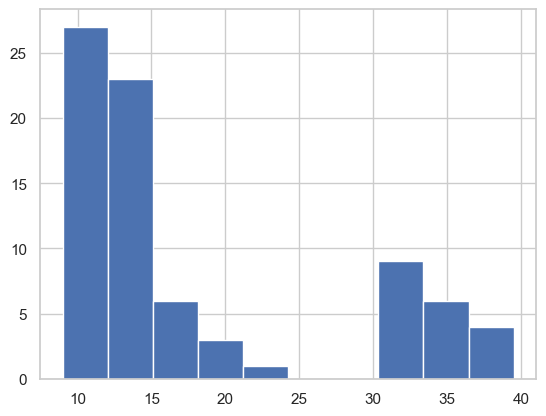

In [54]:
plt.hist([patient.surgical_time - patient.arrival_time for patient in experiment.patients if 'Emergency' in patient.id])

## Scenario 6: Grouping capacity

In [55]:
blank_schedule = schedule.copy()
blank_schedule["patients"] = [[] for _ in range(len(blank_schedule))]

idx_to_drop = []

blank_schedule2 = blank_schedule.copy()
for patient_type, blank_df in blank_schedule2.groupby([blank_schedule2.hour // 24, "patient_type"] ):
    if len(blank_df) > 1:
        first_record_idx = blank_df.iloc[0].name
        for i in range(1, len(blank_df)):
            next_record = blank_df.iloc[i].name

            initial_mask = blank_schedule2.index == first_record_idx
            next_mask = blank_schedule2.index == next_record

            blank_schedule2.loc[initial_mask, "hours_remaining"] += blank_schedule2.loc[next_mask, "hours_remaining"].values
            blank_schedule2.loc[initial_mask, "hours_total"] += blank_schedule2.loc[next_mask, "hours_total"].values

            idx_to_drop.append(blank_df.iloc[i].name)

blank_schedule2 = blank_schedule2.drop(idx_to_drop)

In [56]:
NUM_BEDS = 100
NUM_CC_BEDS = 16

s = Schedule([])

s.processed_schedule = blank_schedule2
s.processed_schedule["hours_remaining"] = s.processed_schedule["hours_total"]

schedule, unprocessed_schedule = create_schedule(theatre_df)
s._Schedule__schedule = unprocessed_schedule

experiment = Experiment(max_emergency_wait=480)
experiment.patients = [*itertools.chain.from_iterable(schedule["patients"].values.tolist())]

for patient in experiment.patients:
    if patient.arrival_time <0:
        s.schedule_patients([patient], patient.surgery_duration)

def patient_generator(env, schedule, experiment):
    while True:
        for patient in experiment.patients:
            if patient.arrival_time == env.now:
                logger.info(f"scheduling patient {patient} now")
                schedule.schedule_patients([patient], env.now)

        yield env.timeout(1)

metrics = defaultdict(lambda : [])
env = simpy.Environment()
logger = setup_logger(env)

beds = simpy.Resource(env, capacity=NUM_BEDS)
cc_beds = simpy.Resource(env, capacity=NUM_CC_BEDS)

initialise_ward(env, beds, init_occupancy_df, metrics)

env.process(patient_generator(env, s, experiment))
env.process(daily_planning(env, beds, s, experiment))
env.process(scheduler(env, beds, cc_beds, experiment, s, metrics))

env.run(until=14*24)


INFO - 336.00 - Scheduling Daycase16 for 57
INFO - 336.00 - Scheduling Elective17 for 9
INFO - 336.00 - Scheduling Elective18 for 57
INFO - 336.00 - Scheduling Elective19 for 57
INFO - 336.00 - Scheduling Daycase79 for 57
INFO - 336.00 - Scheduling Daycase80 for 57
INFO - 336.00 - Scheduling Elective47 for 57
INFO - 336.00 - Scheduling Daycase48 for 57
INFO - 336.00 - Scheduling Daycase0 for 57
INFO - 336.00 - Scheduling Daycase3 for 57
INFO - 336.00 - Scheduling Daycase4 for 57
INFO - 336.00 - Scheduling Daycase5 for 57
INFO - 336.00 - Scheduling Elective82 for 81
INFO - 336.00 - Scheduling Elective83 for 81
INFO - 336.00 - Scheduling Elective49 for 81
INFO - 336.00 - Scheduling Elective50 for 81
INFO - 336.00 - Scheduling Daycase51 for 57
INFO - 336.00 - Scheduling Elective52 for 105
INFO - 336.00 - Scheduling Elective85 for 81
INFO - 336.00 - Scheduling Elective20 for 105
INFO - 336.00 - Scheduling Daycase54 for 81


INFO - 336.00 - Scheduling Elective55 for 9
INFO - 336.00 - Scheduling Daycase34 for 81
INFO - 336.00 - Scheduling Daycase35 for 81
INFO - 336.00 - Scheduling Daycase36 for 81
INFO - 336.00 - Scheduling Elective37 for 57
INFO - 336.00 - Scheduling Elective88 for 134
INFO - 336.00 - Scheduling Elective89 for 153
INFO - 336.00 - Scheduling Elective58 for 81
INFO - 336.00 - Scheduling Daycase59 for 81
INFO - 336.00 - Scheduling Daycase90 for 81
INFO - 336.00 - Scheduling Elective91 for 134
INFO - 336.00 - Scheduling Daycase92 for 81
INFO - 336.00 - Scheduling Elective94 for 177
INFO - 336.00 - Scheduling Elective22 for 81
INFO - 336.00 - Scheduling Elective23 for 225
INFO - 336.00 - Scheduling Daycase38 for 81
INFO - 336.00 - Scheduling Daycase39 for 105
INFO - 336.00 - Scheduling Daycase40 for 105
INFO - 336.00 - Scheduling Daycase41 for 105
INFO - 336.00 - Scheduling Elective64 for 225
INFO - 336.00 - Scheduling Elective65 for 273
INFO - 336.00 - Scheduling Daycase24 for 134
INFO - 336.

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

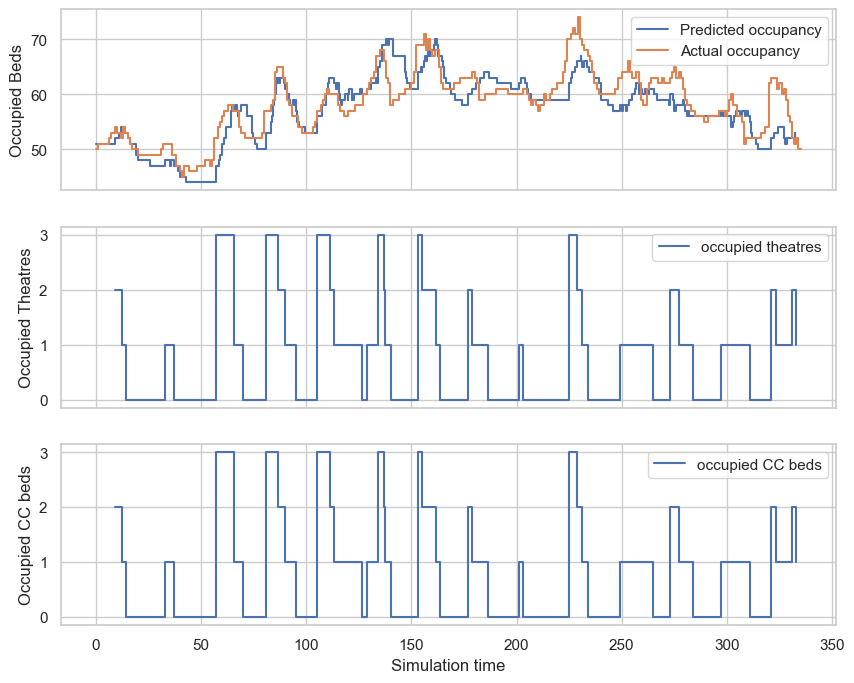

In [57]:
plot_graph(metrics, occupancy_home_df)

In [58]:
metrics["bed_event"].sort(key=lambda e: (e[0], e[1]))

bed_events = np.array(metrics["bed_event"])
beds = bed_events[:, 1].cumsum()
df_beds = pd.DataFrame(np.hstack([bed_events, beds.reshape((-1, 1))]), columns=["Simulation time", "Change", "Occupied beds"]).drop_duplicates(subset="Simulation time", keep='last')

predicted_occ_df = df_beds.set_index("Simulation time")

mae = (predicted_occ_df.reindex(range(0, 14*24)).ffill()["Occupied beds"] - occupancy_home_df.set_index('dst').resample('h').ffill().reset_index(drop=True)["occupancy"]).abs().mean()
print(f"MAE: {mae}")

MAE: 2.7976190476190474


c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


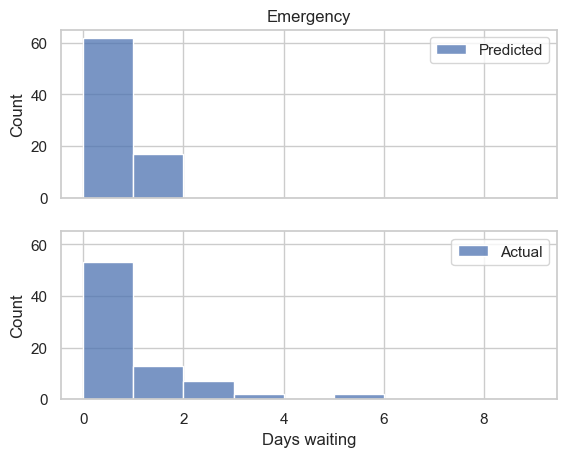

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


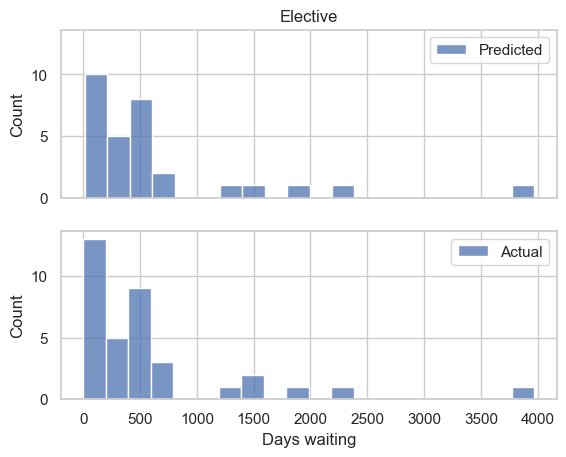

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


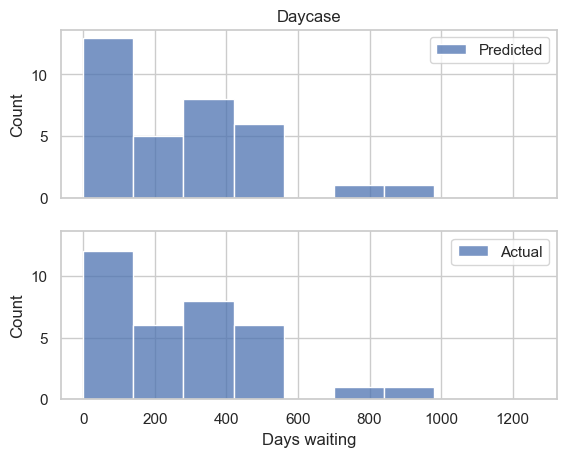

In [59]:
plot_wait_times(experiment, theatre_df)

(array([22., 16., 11.,  8.,  5.,  3.,  1.,  0.,  8.,  5.]),
 array([ 9., 12., 15., 18., 21., 24., 27., 30., 33., 36., 39.]),
 <BarContainer object of 10 artists>)

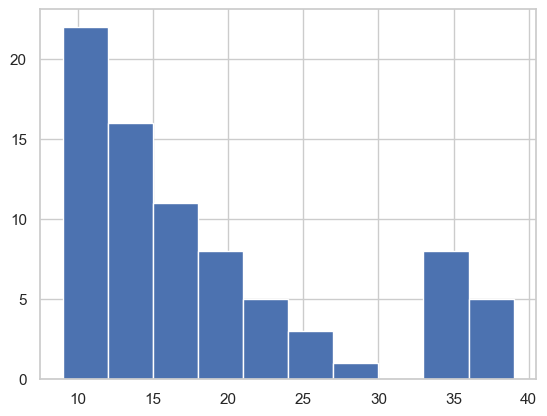

In [60]:
plt.hist([patient.surgical_time - patient.arrival_time for patient in experiment.patients if 'Emergency' in patient.id])

In [61]:
sum([p.surgery_duration for p in experiment.patients]), blank_schedule["hours_total"].sum()

(261.0, 313.5833333333333)

## Scenario 5: Lowering allowed emergency wait

In [62]:
NUM_BEDS = 100
NUM_CC_BEDS = 16

s = Schedule([])

blank_schedule = schedule.copy()
blank_schedule["patients"] = [[] for _ in range(len(blank_schedule))]

s.processed_schedule = blank_schedule
s.processed_schedule["hours_remaining"] = s.processed_schedule["hours_total"]

schedule, unprocessed_schedule = create_schedule(theatre_df)
s._Schedule__schedule = unprocessed_schedule

experiment = Experiment(max_emergency_wait=24)
experiment.patients = [*itertools.chain.from_iterable(schedule["patients"].values.tolist())]

for patient in experiment.patients:
    if patient.arrival_time <0:
        s.schedule_patients([patient], patient.surgery_duration)

metrics = defaultdict(lambda : [])
env = simpy.Environment()
logger = setup_logger(env)

beds = simpy.Resource(env, capacity=NUM_BEDS)
cc_beds = simpy.Resource(env, capacity=NUM_CC_BEDS)

initialise_ward(env, beds, init_occupancy_df, metrics)

env.process(patient_generator(env, s, experiment))
env.process(daily_planning(env, beds, s, experiment))
env.process(scheduler(env, beds, cc_beds, experiment, s, metrics))

env.run(until=14*24)


INFO - 336.00 - Scheduling Daycase16 for 57
INFO - 336.00 - Scheduling Elective17 for 9
INFO - 336.00 - Scheduling Elective18 for 57
INFO - 336.00 - Scheduling Elective19 for 57
INFO - 336.00 - Scheduling Daycase79 for 57
INFO - 336.00 - Scheduling Daycase80 for 57
INFO - 336.00 - Scheduling Elective47 for 57
INFO - 336.00 - Scheduling Daycase48 for 57
INFO - 336.00 - Scheduling Daycase0 for 57
INFO - 336.00 - Scheduling Daycase3 for 57
INFO - 336.00 - Scheduling Daycase4 for 57
INFO - 336.00 - Scheduling Daycase5 for 57
INFO - 336.00 - Scheduling Elective82 for 81
INFO - 336.00 - Scheduling Elective83 for 81
INFO - 336.00 - Scheduling Elective49 for 81
INFO - 336.00 - Scheduling Elective50 for 81
INFO - 336.00 - Scheduling Daycase51 for 81
INFO - 336.00 - Scheduling Elective52 for 105
INFO - 336.00 - Scheduling Elective85 for 81
INFO - 336.00 - Scheduling Elective20 for 105
INFO - 336.00 - Scheduling Daycase54 for 81
INFO - 336.00 - Scheduling Elective55 for 9
INFO - 336.00 - Scheduli

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

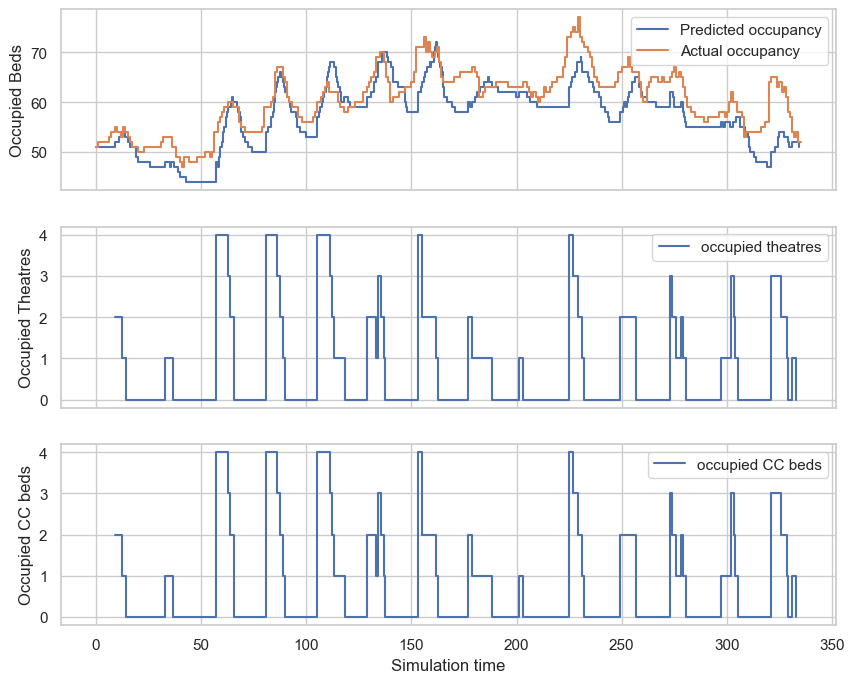

In [63]:
plot_graph(metrics)

(array([27., 23.,  6.,  3.,  1.,  0.,  0.,  9.,  6.,  4.]),
 array([ 9.  , 12.05, 15.1 , 18.15, 21.2 , 24.25, 27.3 , 30.35, 33.4 ,
        36.45, 39.5 ]),
 <BarContainer object of 10 artists>)

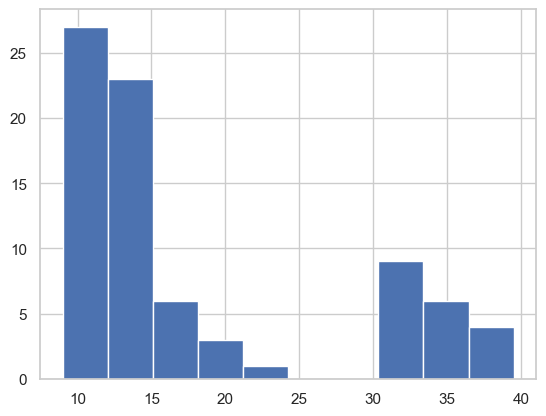

In [64]:
plt.hist([patient.surgical_time - patient.arrival_time for patient in experiment.patients if 'Emergency' in patient.id])
# If the patient is breaching the time, but booked in on that day, they are not rebooked.